# Watershed 2D 3D

Here we develop and evaluate the method of postprocessing of probability images produced by neural network.

Methods used here revolve around using watershed variants:
- intensity based
- distance transform based

Current experiments used:
- vanila watershed
- using threshold or peaks as markers
- combining intensity and distance information
- evaluating 3d usage of watershed 

Usable solutions:
- using watershed solution inspired by CellProfiler Watershed module (extended by some preprocessing and merging intensity)

In [1]:
from notebook_utils import *

import imageio
import skimage.segmentation
import skimage.filters

import scipy.stats

import random

import os
import shutil

%matplotlib inline

# Load input data

In [2]:
# general
dir_root = r'D:\Fafa\MIT\CellDx\watersheds'

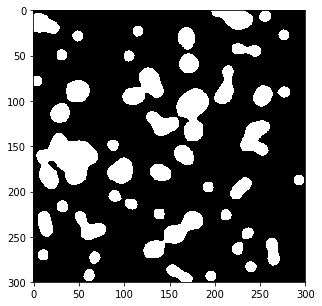

In [3]:
from skimage import data

synthetic = data.binary_blobs(300, volume_fraction=0.2,seed=10)
show_all(1,1,synthetic, scale=5)

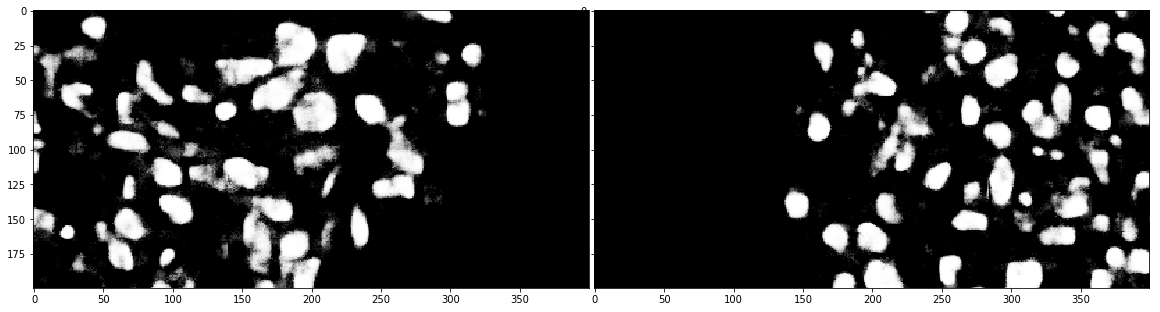

In [4]:
path_2d = os.path.join(dir_root, '017.tif')

cp_segm = imageio.imread(path_2d)
crop_1 = cp_segm[200:400,0:400] / 255.0
crop_2 = cp_segm[400:600,600:1000] / 255.0
show_all(1,2,crop_1, crop_2, scale=20)

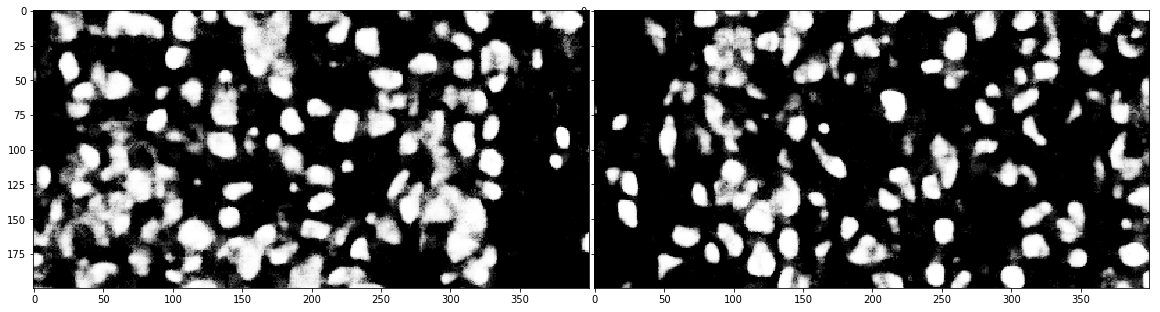

In [5]:
path_2d_2 = os.path.join(dir_root, '072.tif')

cp_segm_2 = imageio.imread(path_2d_2)
crop_b1 = cp_segm_2[200:400,0:400] / 255.0
crop_b2 = cp_segm_2[400:600,600:1000] / 255.0
show_all(1,2,crop_b1, crop_b2, scale=20)

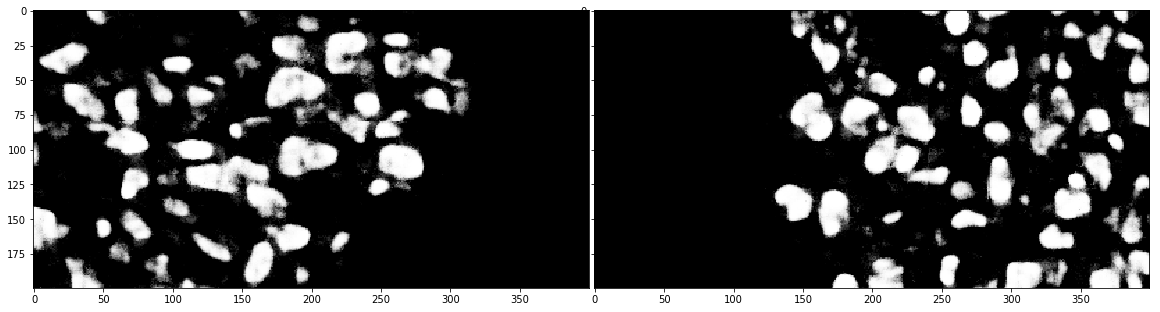

In [6]:
path_3d = os.path.join(dir_root, 'substack.tif')
cp_segm_3 = imageio.volread(path_3d) / 255.0
crop_3d_1 = cp_segm_3[::, 200:400,0:400] 
crop_3d_2 = cp_segm_3[::, 400:600,600:1000] 
show_all(1,2,crop_3d_1[0], crop_3d_2[-5], scale=20)

## Vanila watershed 
Let's start with using watershed 3d provided by skimage.

In [7]:
from skimage.morphology import watershed, label, opening
# check also skimage.segmentation.random_walker

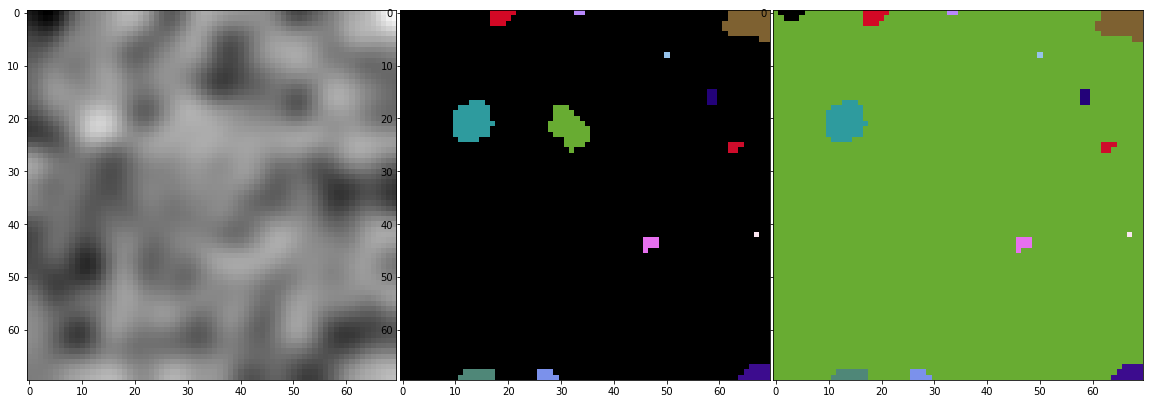

In [8]:
np.random.seed(1)
imag = np.random.random((70,70))
imag = scipy.ndimage.gaussian_filter(imag, 3)
mark = label(imag>0.54)
test_wat = watershed(imag, mark, mask=imag > 0.4,compactness=0.0)
show_all(1,3,imag, mark, test_wat, scale=20, cmap='gray,rand,rand')

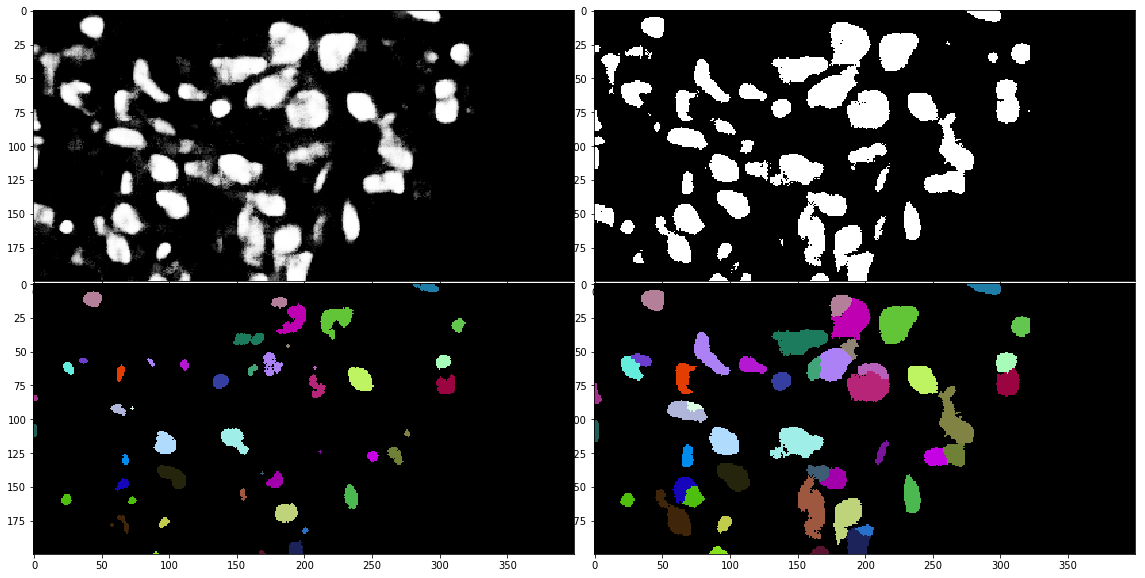

In [9]:
maska = crop_1>0.5

tops = crop_1>0.98
markers = label(tops)
markers = opening(markers)
show_all(2,1,tops, markers, scale=20, cmap='gray,rand')
what_mark = watershed(1-crop_1, markers, mask=maska, compactness=0.0)
show_all(2,2,crop_1, maska, markers, what_mark, scale=20, cmap='gray,gray,rand,rand')

### Distance transform

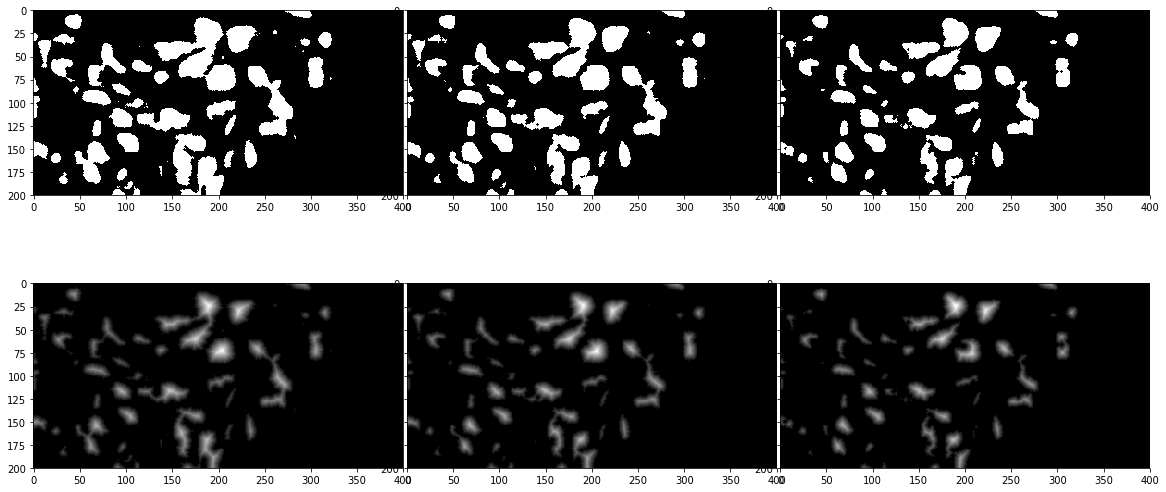

In [10]:
from skimage.morphology import closing
from scipy import ndimage as ndi
mask03 = closing(crop_1 > 0.3)
mask05 = closing(crop_1 > 0.5)
mask07 = closing(crop_1 > 0.7)
distance03 = ndi.distance_transform_edt(mask03)
distance05 = ndi.distance_transform_edt(mask05)
distance07 = ndi.distance_transform_edt(mask07)
show_all(2,3,mask03,mask05,mask07, distance03, distance05, distance07, scale=20)

#### Threshold for peaks

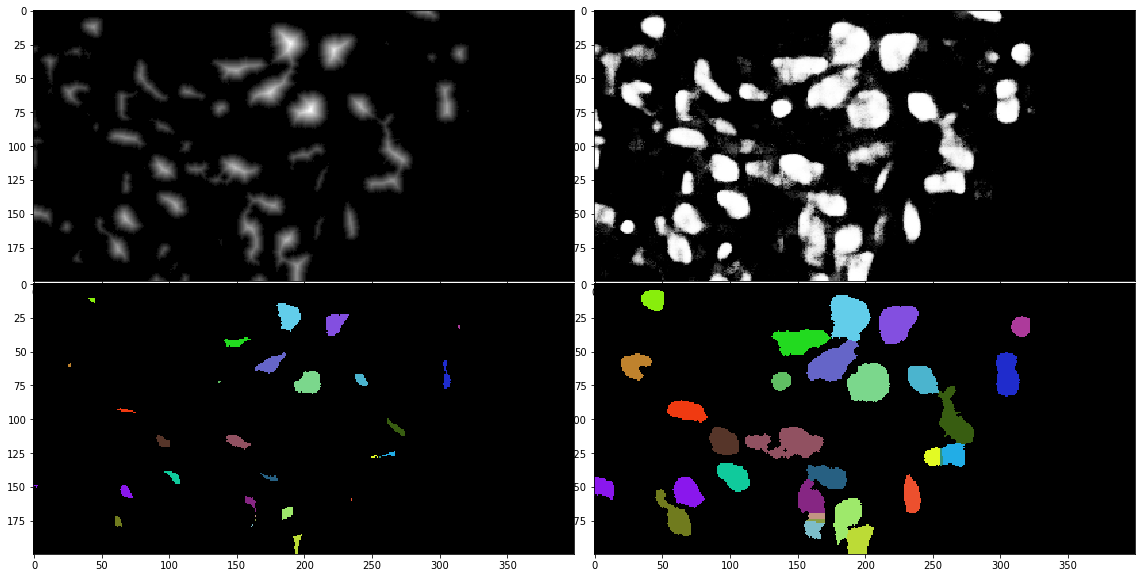

In [11]:
tops_dist = distance05>6
markers_dist = label(tops_dist)
labels_dist = watershed(-distance05, markers_dist, mask=mask05)
show_all(2,2,distance05,crop_1,markers_dist, labels_dist, scale=20, cmap="gray,gray,rand,rand")

#### Local minima for peaks

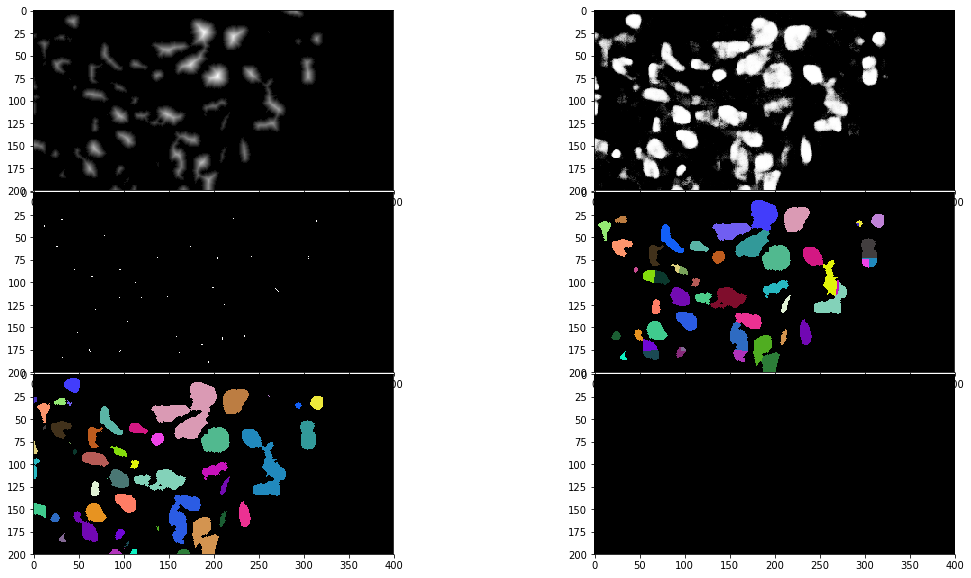

In [12]:
from skimage.feature import peak_local_max
rough_labels = label(mask05)
local_maxi = peak_local_max(distance05, threshold_abs=2, labels=rough_labels, num_peaks_per_label=5, indices=False, min_distance=10)
markers = ndi.label(local_maxi)[0]
## limit number of peaks by using rough labeling
labels_dist = watershed(-distance05, markers, mask=mask05)
show_all(3,2,distance05,crop_1,local_maxi, labels_dist, rough_labels, scale=20, cmap="gray,gray,gray,rand,rand")

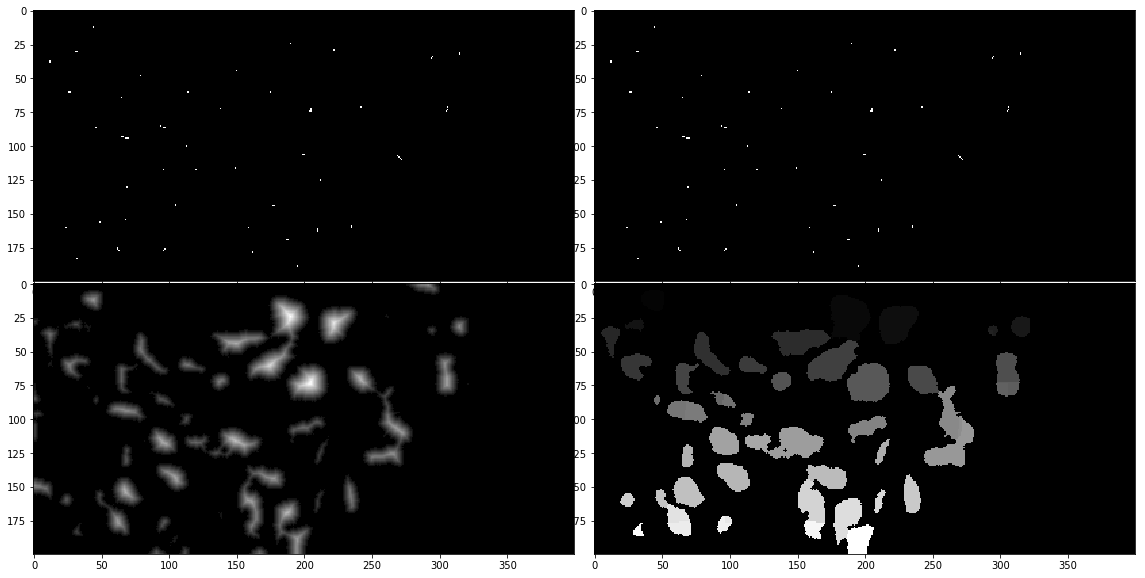

In [13]:
show_all(2,2,local_maxi,markers>0,distance05,labels_dist, scale=20, cmap="gray,gray")

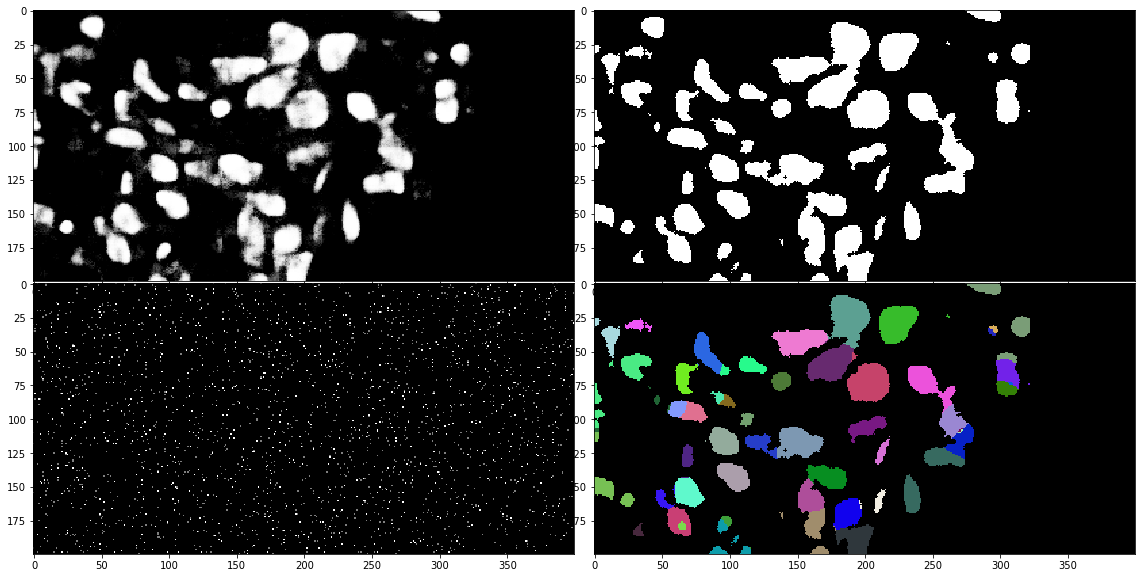

In [14]:
from skimage.segmentation import random_walker

random_data = np.random.random(crop_1.shape)
random_markers = (random_data > 0.98) * 1 + (random_data < 0.01) * 2

# stretch distance, maybe it is important

labels = random_walker(-distance05, markers, beta=10, mode='bf') * mask05
show_all(2,2,crop_1,mask05,random_markers, labels, scale=20, cmap="gray,gray,gray,rand")

## Merge probability and distance information

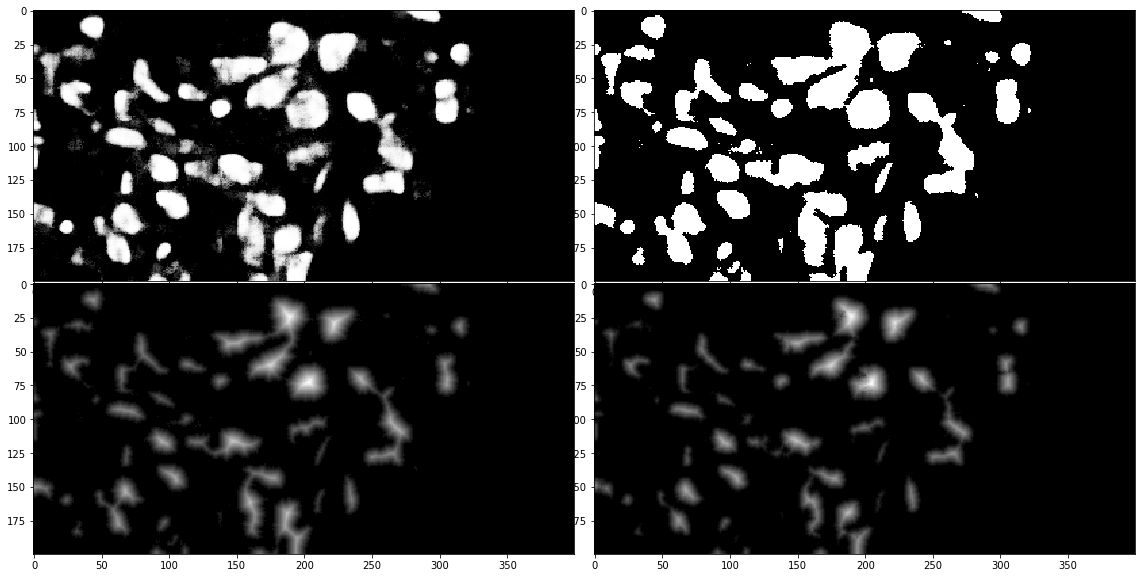

In [15]:
show_all(2,2,crop_1,mask03,distance03, crop_1* distance05, scale=20, cmap="gray,gray")

## Distance and processing in 3D

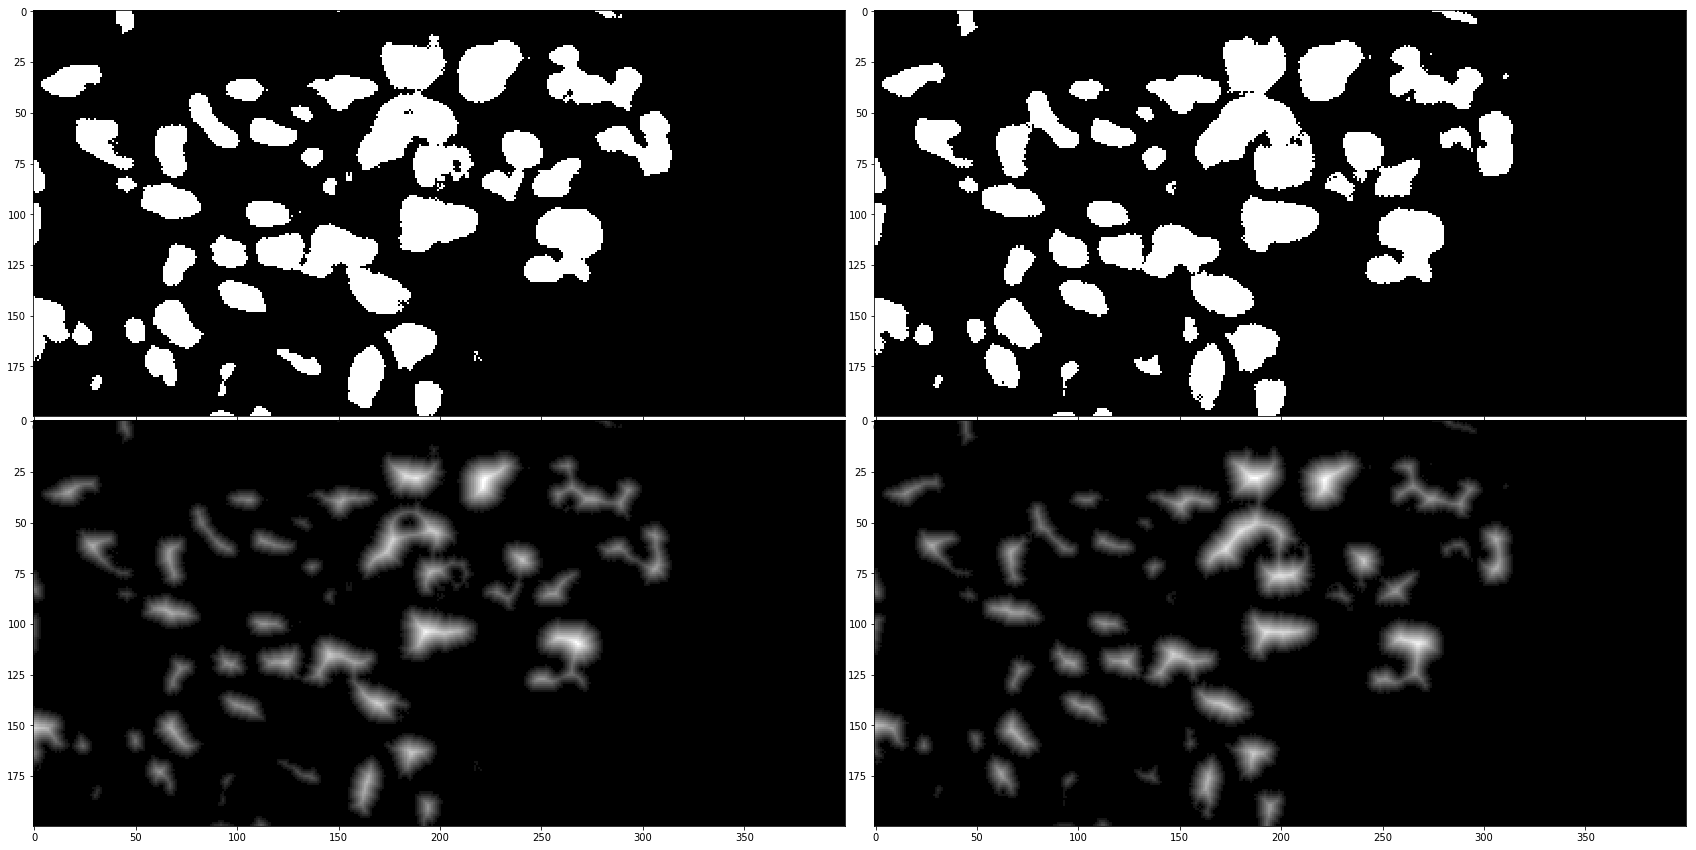

In [83]:
crop_3d_1_mask = closing(crop_3d_1 > 0.5)
crop_3d_1_mask_distance3 = ndi.distance_transform_edt(crop_3d_1_mask[3], sampling=[1,1])
crop_3d_1_mask_distance4 = ndi.distance_transform_edt(crop_3d_1_mask[4], sampling=[1,1])

show_all(2,2, crop_3d_1_mask[3], crop_3d_1_mask[4], crop_3d_1_mask_distance3, crop_3d_1_mask_distance4, cmap='gray')

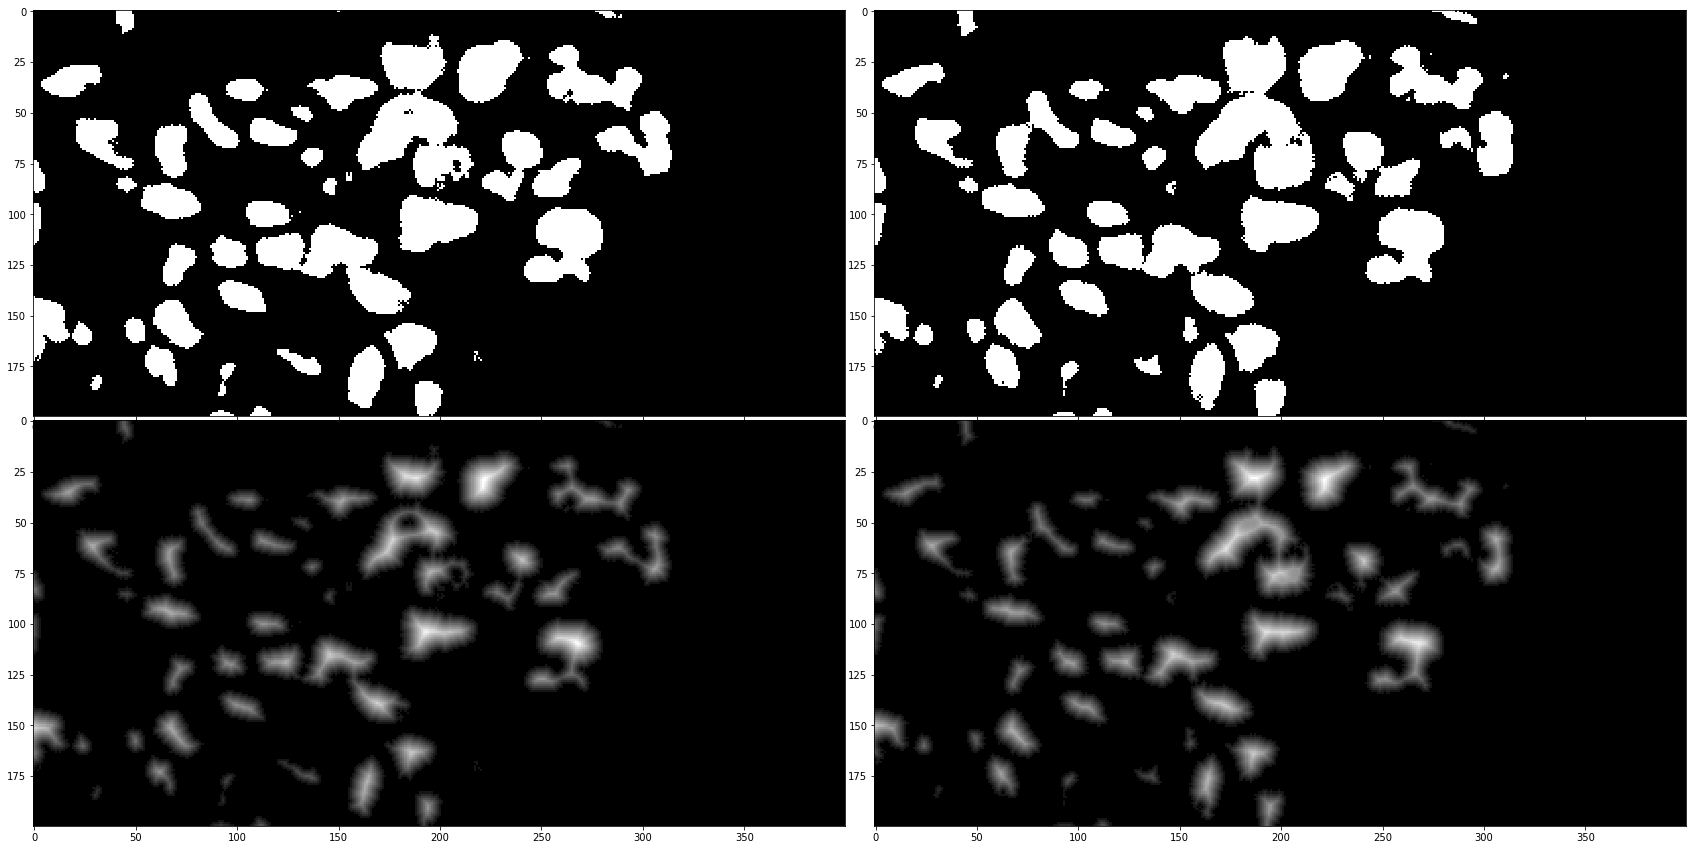

In [96]:
crop_3d_1_mask = closing(crop_3d_1 > 0.5)
crop_3d_1_mask_distance = ndi.distance_transform_edt(crop_3d_1_mask, sampling=[7,1,1])

show_all(2,2, crop_3d_1_mask[3], crop_3d_1_mask[4], crop_3d_1_mask_distance[3], crop_3d_1_mask_distance[4], cmap='gray')

# CellProfiler watershed ideas

In [136]:
import instance.watersheds as wmahotas
importlib.reload(wmahotas);

In [137]:
def run_mahotas(image, use_intensity, thresh, meds, sup, smoo, zs=None):
    maska = closing(image > thresh)
    med = scipy.ndimage.median_filter(maska, meds)
    intensity = image if use_intensity else None
    wat = wmahotas.distance_watershed(maska, intensity=intensity, suppress=sup, smooth=smoo, z_ratio=zs)
    return wat

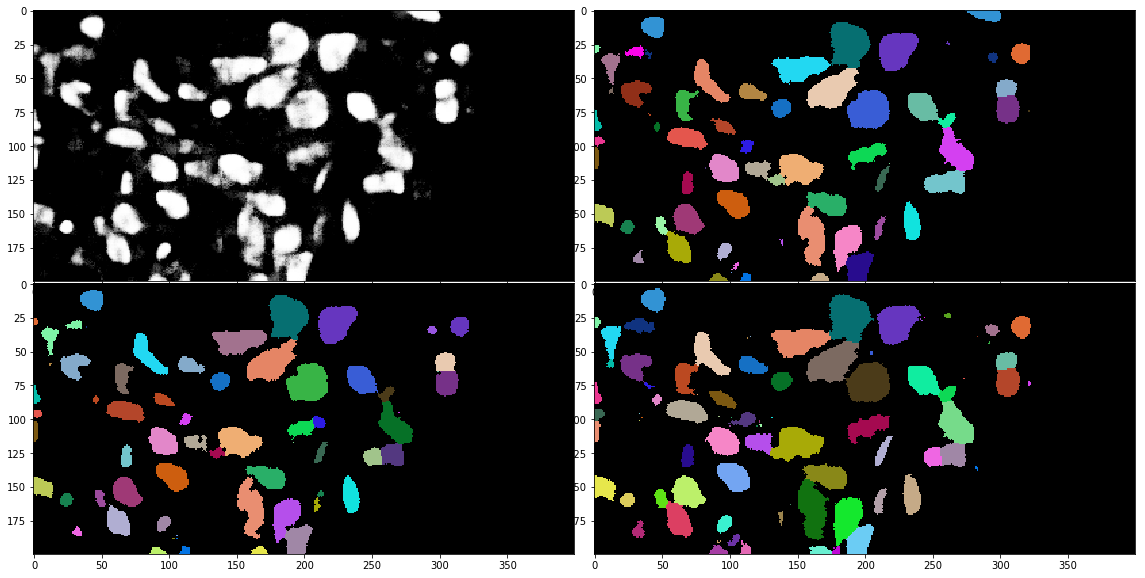

In [138]:
input_temp = crop_1
show_all(2,2,input_temp, run_mahotas(input_temp, False, thresh=0.5, meds=3, sup=5, smoo=2), 
         run_mahotas(input_temp, False, thresh=0.6, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, False, thresh=0.3, meds=3, sup=5, smoo=2),scale=20, cmap="gray,rand,rand,rand,rand")

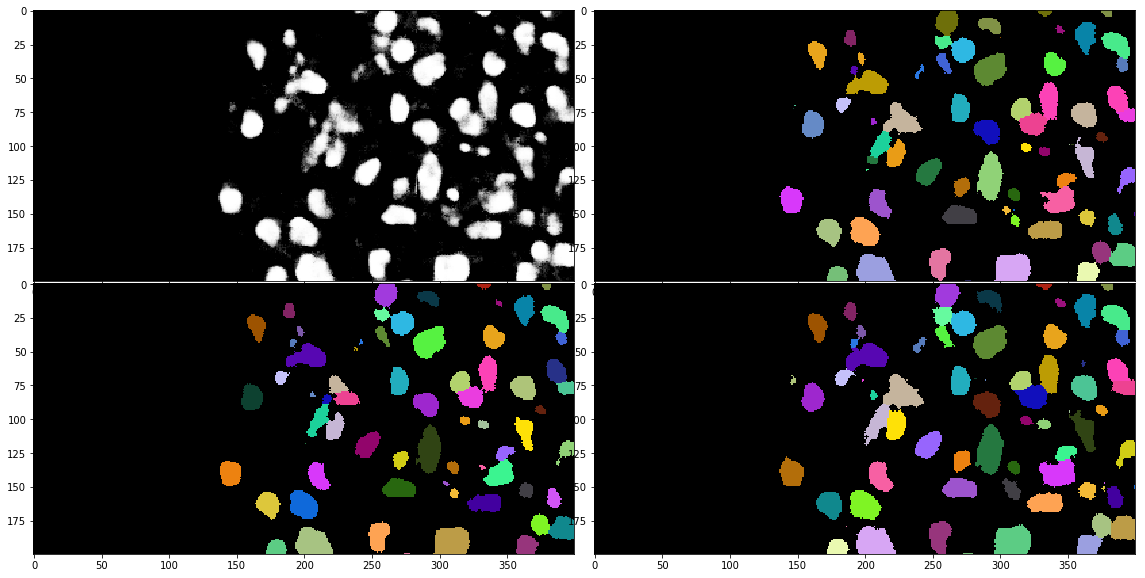

In [106]:
input_temp = crop_2
show_all(2,2,input_temp, run_mahotas(input_temp, False, thresh=0.5, meds=3, sup=5, smoo=2), 
         run_mahotas(input_temp, False, thresh=0.6, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, False, thresh=0.3, meds=3, sup=5, smoo=2),scale=20, cmap="gray,rand,rand,rand,rand")

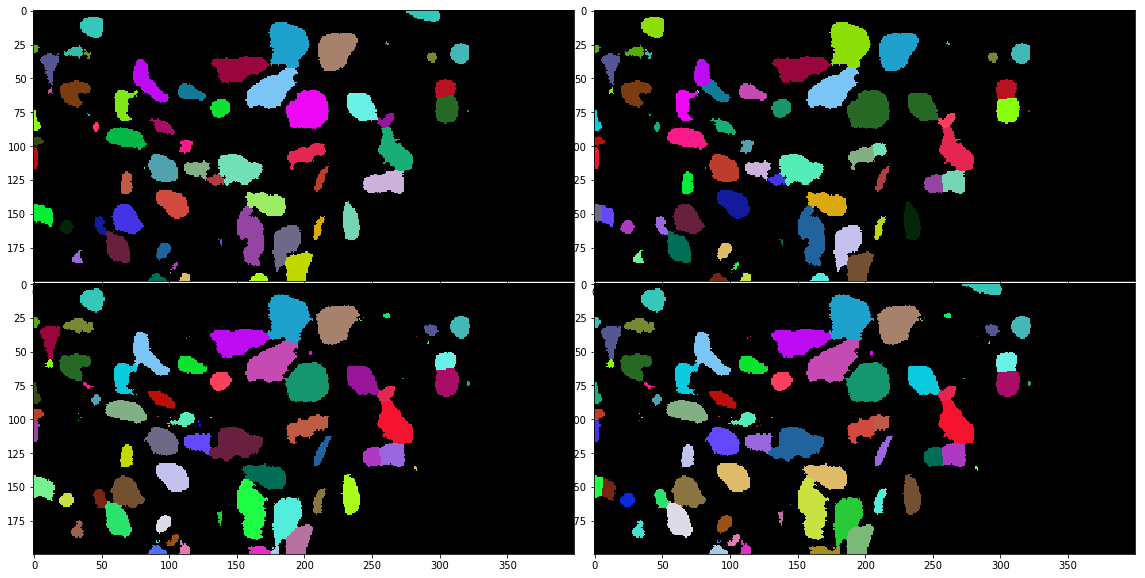

In [107]:
input_temp = crop_1
show_all(2,2,run_mahotas(input_temp, False, thresh=0.5, meds=3, sup=5, smoo=2), 
         run_mahotas(input_temp, True, thresh=0.5, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, False, thresh=0.3, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, True, thresh=0.3, meds=3, sup=5, smoo=2),scale=20, cmap="rand")

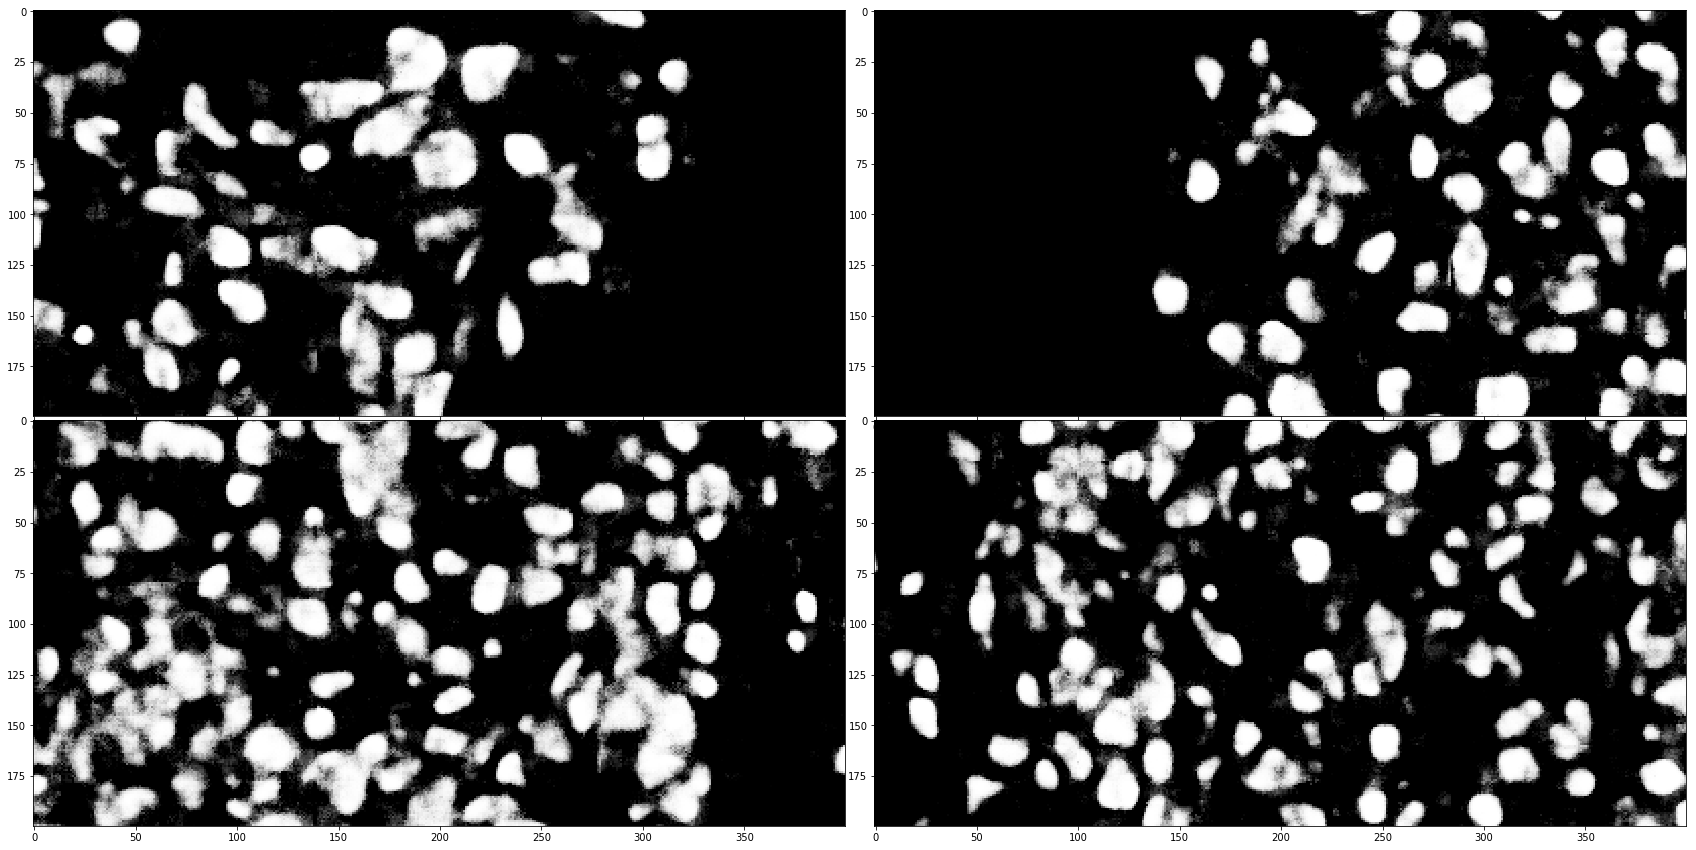

In [108]:
show_all(2,2,crop_1, crop_2,crop_b1,crop_b2) 

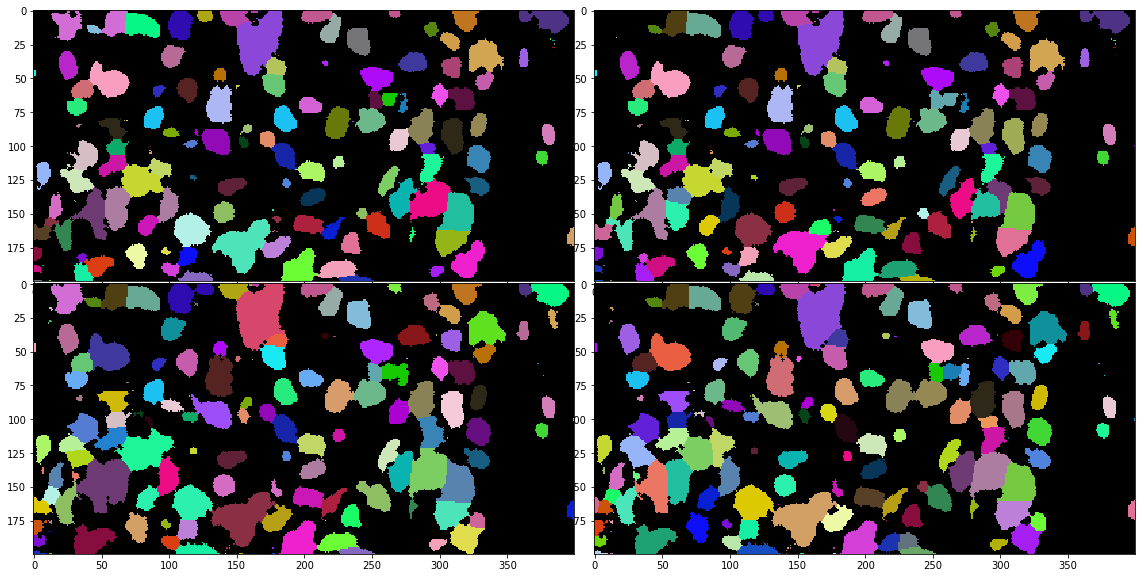

In [109]:
input_temp = crop_b1
show_all(2,2,run_mahotas(input_temp, False, thresh=0.5, meds=3, sup=5, smoo=2), 
         run_mahotas(input_temp, True, thresh=0.5, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, False, thresh=0.3, meds=3, sup=5, smoo=2),
         run_mahotas(input_temp, True, thresh=0.3, meds=3, sup=5, smoo=2),scale=20, cmap="rand")

## Watershed in 3d

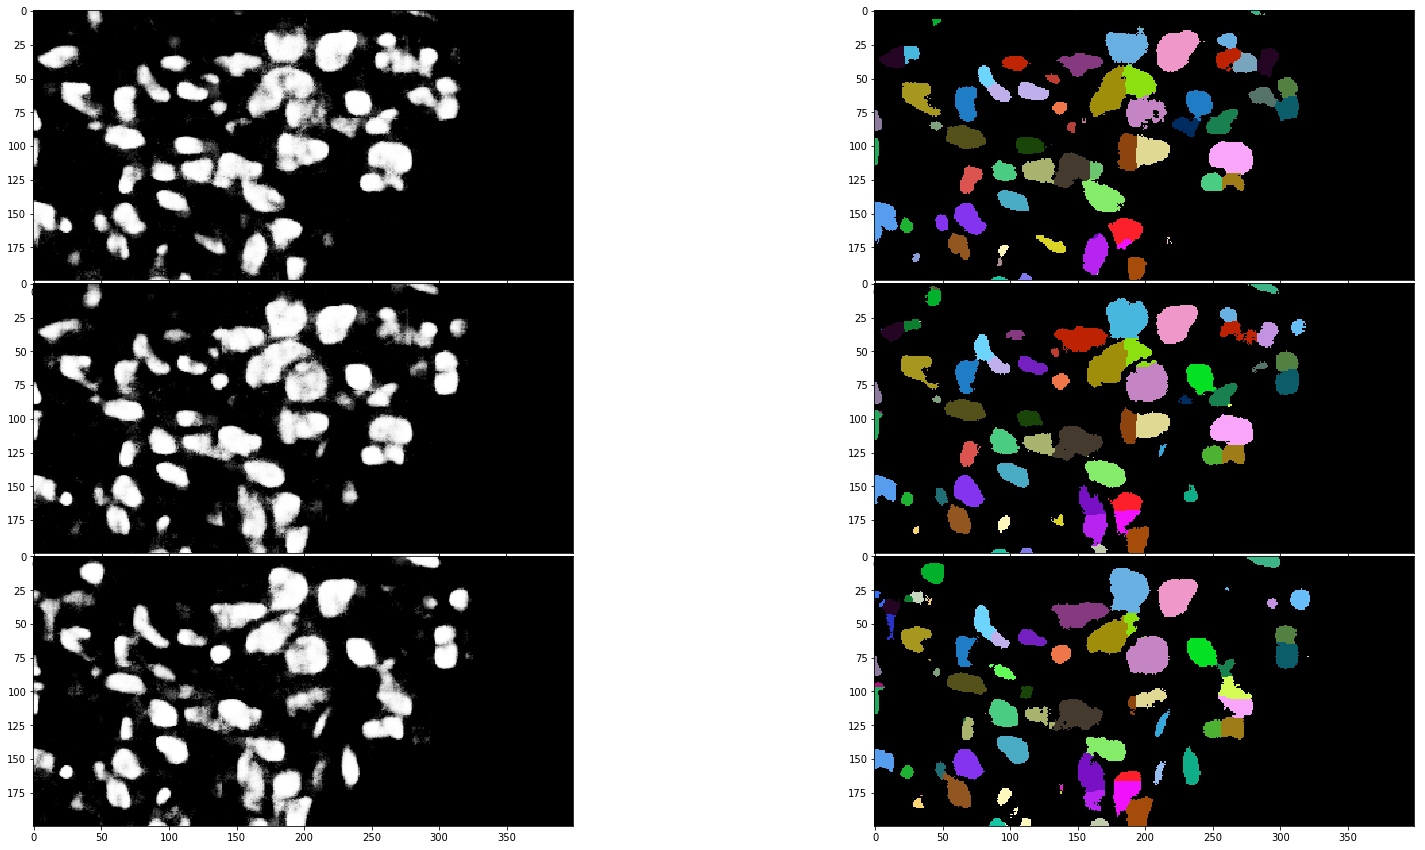

In [134]:
crop_3d_1_water = run_mahotas(crop_3d_1, True, thresh=0.5, meds=3, sup=5, smoo=2, zs=0.2)

show_all(3,2, crop_3d_1[3], crop_3d_1_water[3], crop_3d_1[5], crop_3d_1_water[5], crop_3d_1[7], crop_3d_1_water[7], cmap='gray,rand')

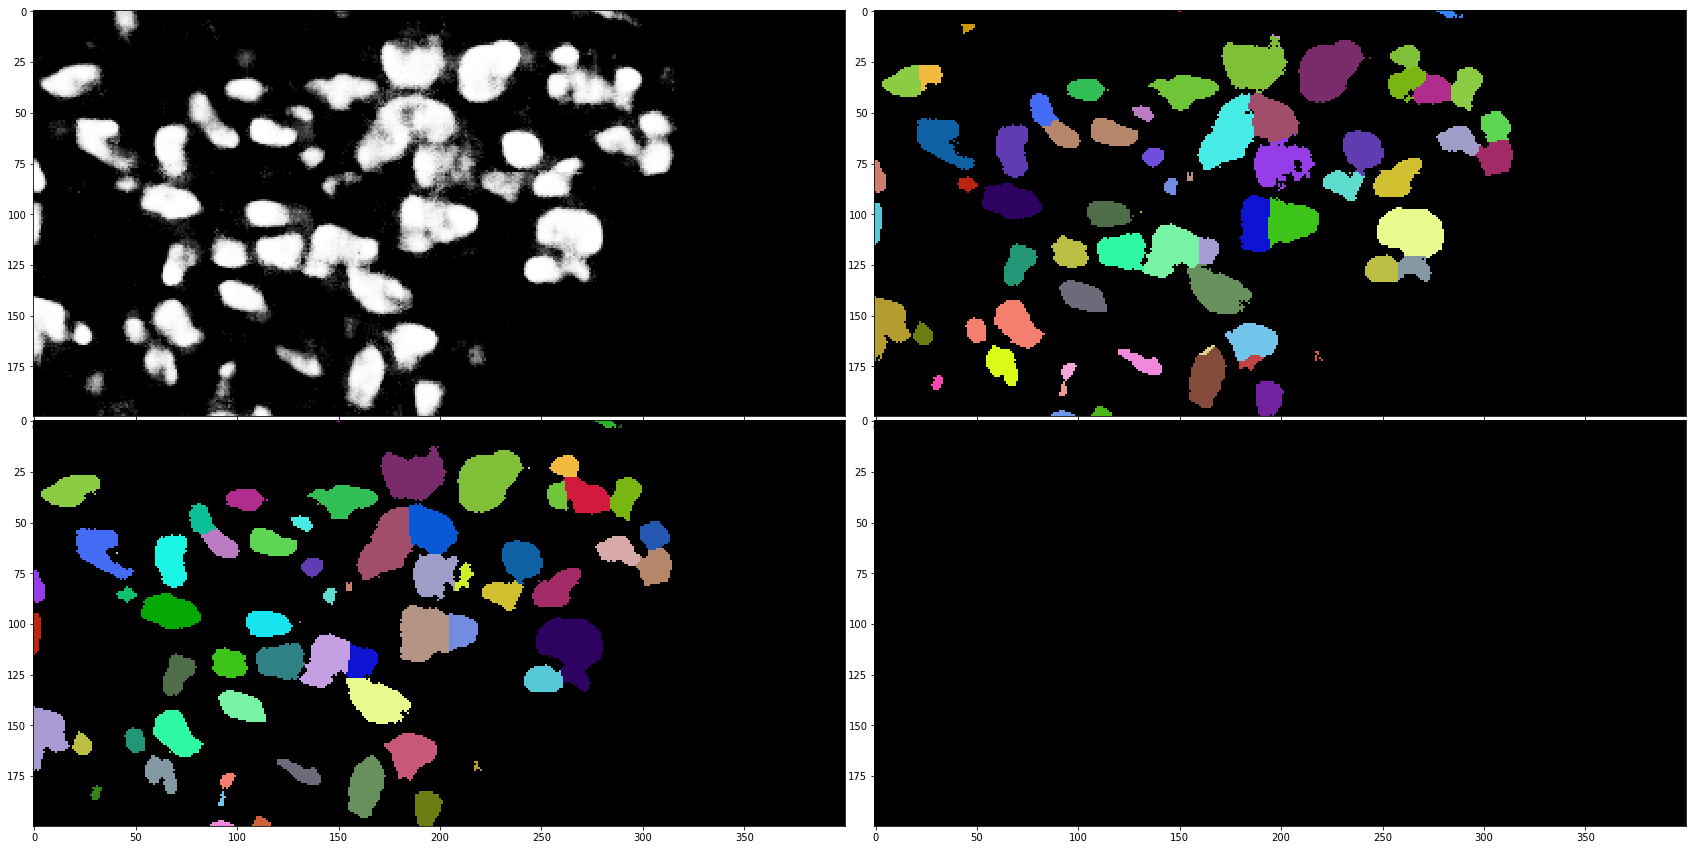

In [135]:
crop_3d_1_water3 = run_mahotas(crop_3d_1[3], True, thresh=0.5, meds=3, sup=5, smoo=2, zs=0.5)

show_all(2,2, crop_3d_1[3], crop_3d_1_water[3], crop_3d_1_water3, cmap='gray,rand,rand')